# Galaxy Morphology Classification with ConvNeXt-Base

### This notebook demonstrates galaxy morphology classification using the ConvNeXt-Base deep learning model. It covers data loading from the Galaxy10 DECals dataset, preprocessing and augmentation, model definition and training, evaluation with metrics and visualizations, and analysis of classification results. The workflow includes device setup, stratified data splitting, custom PyTorch dataset and dataloaders, model checkpointing, and performance reporting.

## Device Setup

In [ ]:
import torch
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Supress warnings

In [ ]:
import warnings
# Supress unnecessary warnings
warnings.filterwarnings("ignore")


## Install Libraries

In [ ]:
# Installs the astroNN package, required for dataset loading
!pip install astroNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.9 MB/s eta 0:00:00


## Import Libraries

In [ ]:
# Imports all necessary libraries for data handling, model building, training, and evaluation
import time
import os
import random
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T

import torch.nn as nn
from torchvision import models

import torch.optim as optim
from torch.cuda import amp
import torch.nn.functional as F

from astroNN.datasets import load_galaxy10
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight


## Load Dataset

In [5]:
images, labels = load_galaxy10()
y = labels.astype(np.int64)
X = images
print("X:", X.shape, X.dtype, " y:", y.shape, y.dtype)

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [00:56<00:00, 39.6MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [01:03, 42.8MB/s]                            


X: (17736, 256, 256, 3) uint8  y: (17736,) int64


## Class Mappings and Visualisations

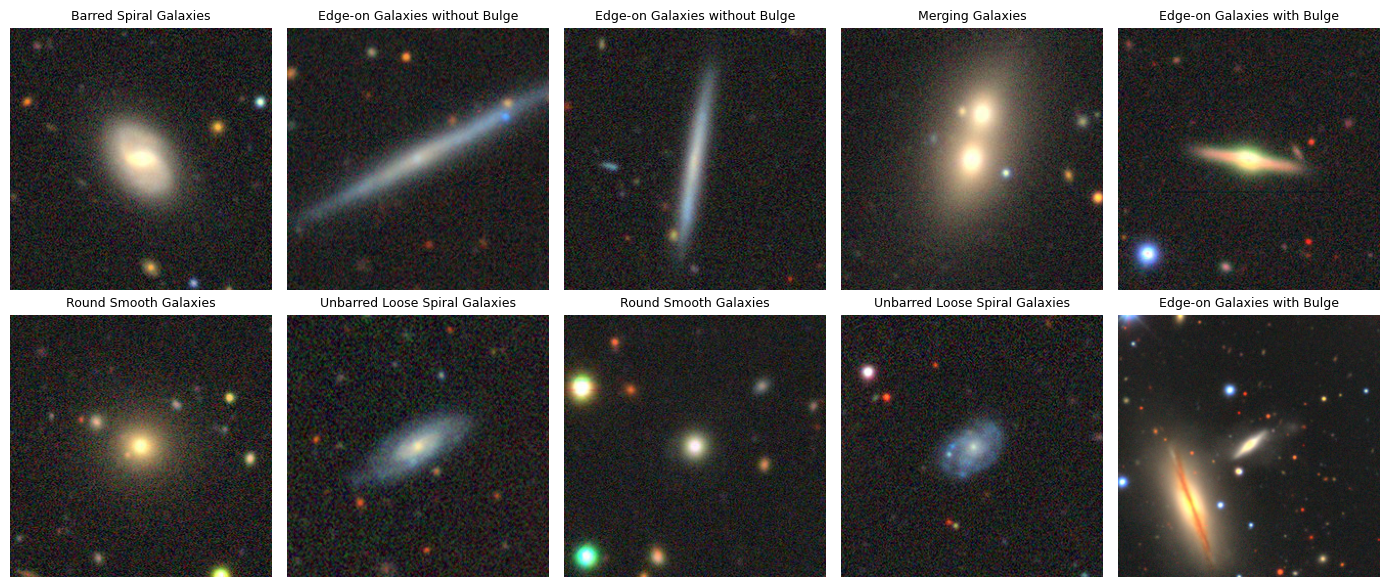

In [6]:

# Class mapping for Galaxy10 DECals
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge",
}

# Plot a few random examples
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for ax in axes.flat:
    idx = np.random.randint(0, len(images))
    ax.imshow(images[idx])
    ax.set_title(class_names[labels[idx]], fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Dataset class (flip + tiny rotate + color jitter + normalize)

In [7]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class GalaxyDecalsDataset(Dataset):
  def __init__(self, images, labels, img_size=(224,224), train=True):
    self.images = images
    self.labels = labels.astype(np.int64)

    if train:
      self.transform = T.Compose([
        T.Resize(img_size, antialias=True),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=5),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
      ])
    else:
      self.transform = T.Compose([
        T.ToTensor(),
        T.Resize(img_size, antialias=True),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
      ])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img = Image.fromarray(self.images[index])
    x = self.transform(img)
    y = torch.tensor(self.labels[index], dtype=torch.long)
    return x, y

## Dataloaders (train/val/test)

In [ ]:


# stratified split
N = len(images)

# First split: train (70%) vs temp (30%)
train_idx, temp_idx = train_test_split(
    np.arange(N),
    test_size=0.30,
    random_state=42,
    stratify=labels
)

# Second split: val (15%) vs test (15%) from temp
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,  # half of 30% = 15%
    random_state=42,
    stratify=labels[temp_idx]
)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

# build datasets 
train_dataset = Subset(GalaxyDecalsDataset(images, labels, img_size=(224,224), train=True),  train_idx)
val_dataset   = Subset(GalaxyDecalsDataset(images, labels, img_size=(224,224), train=False), val_idx)
test_dataset  = Subset(GalaxyDecalsDataset(images, labels, img_size=(224,224), train=False), test_idx)

# loaders 
BATCH_SIZE   = 64
NUM_WORKERS  = 4
PIN          = torch.cuda.is_available()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN)

# sanity check 
xb, yb = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape, yb.dtype)


Train: 12415, Val: 2660, Test: 2661
Batch: torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.int64


## Model definition

In [ ]:

# Define the ConvNeXt-based model for Galaxy Morphology Classification
class ConvNeXtGalaxy(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()
        m = models.convnext_base(
            weights=models.ConvNeXt_Base_Weights.IMAGENET1K_V1 if pretrained else None
        )
        # Grab feature dim from the original classifier's Linear
        in_features = m.classifier[-1].in_features  # 1024 for ConvNeXt-Base
        # Remove the stock classifier; we'll add our own head
        m.classifier = nn.Identity()
        self.backbone = m
        self.head = nn.Sequential(
            nn.LayerNorm(in_features),
            nn.Linear(in_features, 124), nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(124, num_classes),
        )

    def forward(self, x):
        feat_map = self.backbone(x)          # [B, C, H, W]
        feat = feat_map.mean(dim=(2, 3))     # global average pool -> [B, C]
        return self.head(feat)               # [B, num_classes]



Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|██████████| 338M/338M [00:01<00:00, 234MB/s]


## Model Instantiation

In [10]:
# instantiate
model = ConvNeXtGalaxy(num_classes=10, pretrained=True).to(device)

print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Trainable params: 87694814


## Loss, Optimizer, Schedular, AMP

In [ ]:
# Sets up the loss function with class weights to handle class imbalance
weights = compute_class_weight("balanced", classes=np.arange(10), y=labels)
crit = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=device, dtype=torch.float))


# Optimizer (single LR for everything) 
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=3e-4)

# Scheduler (cosine decay across epochs) 
EPOCHS = 30
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# AMP Scaler (mixed precision if on GPU) 
scaler = torch.cuda.amp.GradScaler(enabled=(torch.cuda.is_available() and str(device) == "cuda"))

## Training and Evaluation Functions

In [ ]:
# Train one epoch 
def train_epoch(model, loader, loss_fn, optimizer, device, scaler):
    model.train()
    train_loss, correct, n = 0.0, 0, 0

    for imgs, y in loader:
        imgs, y = imgs.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(imgs)             # [B, 10]
            loss = loss_fn(logits, y)        # CrossEntropyLoss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # metrics
        bs = y.size(0)
        train_loss += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        n += bs

    avg_loss = train_loss / n
    avg_acc  = correct / n
    return avg_loss, avg_acc


# Evaluate one epoch 
@torch.no_grad()
def eval_epoch(model, loader, loss_fn, device):
    model.eval()
    val_loss, correct, n = 0.0, 0, 0

    for imgs, y in loader:
        imgs, y = imgs.to(device), y.to(device)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(imgs)
            loss = loss_fn(logits, y)

        bs = y.size(0)
        val_loss += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        n += bs

    avg_loss = val_loss / n
    avg_acc  = correct / n
    return avg_loss, avg_acc


## Training Loop

In [ ]:
import time
import torch

# Config 
EPOCHS   = 30
PATIENCE = 10
best_val_loss = float("inf")
patience_counter = 0

best_model_path = "Convex_next.pt"

history = {
    "train_loss": [],
    "train_acc":  [],
    "val_loss":   [],
    "val_acc":    [],
}

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # Train 
    train_loss, train_acc = train_epoch(
        model, train_loader, crit, optimizer, device, scaler
    )

    # Validate 
    val_loss, val_acc = eval_epoch(
        model, val_loader, crit, device
    )

    # Scheduler step 
    scheduler.step()

    # Log 
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    dt = time.time() - t0
    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"train_loss {train_loss:.4f} acc {train_acc:.3f} | "
        f"val_loss {val_loss:.4f} acc {val_acc:.3f} | "
        f"{dt:.1f}s"
    )

    # Checkpoint & Early Stop 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history,
            "note": "Swittransformer | CrossEntropyLoss"
        }, best_model_path)
        print("Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best & TEST 
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt["model_state"])

test_loss, test_acc = eval_epoch(model, test_loader, crit, device)

print("\n=== Test Results (best checkpoint) ===")
print(f"Loss: {test_loss:.4f}")
print(f"Acc : {test_acc:.3f}")


Epoch 01/30 | train_loss 1.1296 acc 0.614 | val_loss 0.6426 acc 0.806 | 62.5s
Saved new best model
Epoch 02/30 | train_loss 0.7642 acc 0.754 | val_loss 0.5178 acc 0.821 | 29.2s
Saved new best model
Epoch 03/30 | train_loss 0.6333 acc 0.803 | val_loss 0.5577 acc 0.817 | 29.5s
Epoch 04/30 | train_loss 0.5991 acc 0.810 | val_loss 0.5916 acc 0.801 | 29.9s
Epoch 05/30 | train_loss 0.5141 acc 0.834 | val_loss 0.6179 acc 0.828 | 30.1s
Epoch 06/30 | train_loss 0.4687 acc 0.849 | val_loss 0.5110 acc 0.844 | 30.1s
Saved new best model
Epoch 07/30 | train_loss 0.4389 acc 0.858 | val_loss 0.4651 acc 0.848 | 30.2s
Saved new best model
Epoch 08/30 | train_loss 0.4029 acc 0.872 | val_loss 0.5280 acc 0.845 | 30.3s
Epoch 09/30 | train_loss 0.3570 acc 0.886 | val_loss 0.5274 acc 0.844 | 30.1s
Epoch 10/30 | train_loss 0.3240 acc 0.895 | val_loss 0.4740 acc 0.859 | 30.1s
Epoch 11/30 | train_loss 0.2977 acc 0.904 | val_loss 0.5701 acc 0.842 | 30.1s
Epoch 12/30 | train_loss 0.2611 acc 0.917 | val_loss 0.524

## Plotting Results

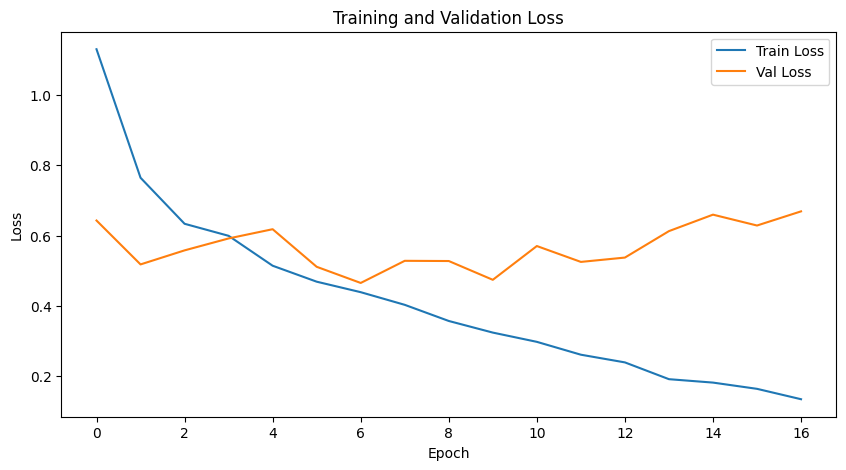

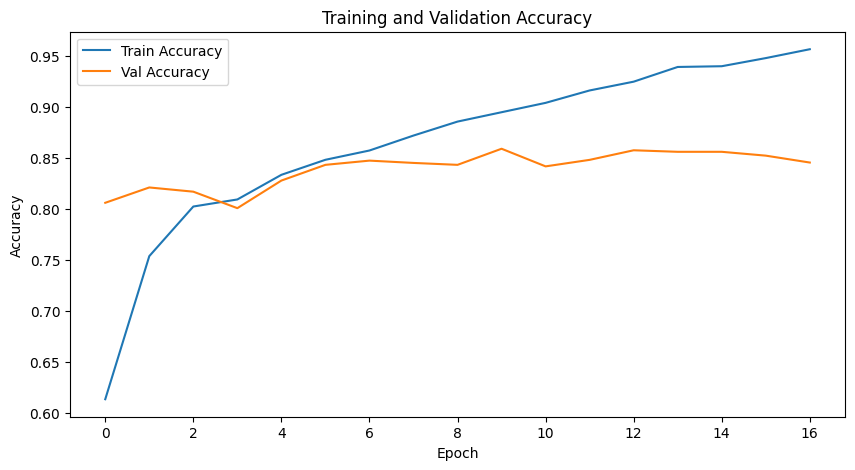

In [ ]:

# Plots training and validation loss and accuracy over epochs

# Plot Loss 
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Accuracy 
plt.figure(figsize=(10, 5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


## Evaluation and Analysis

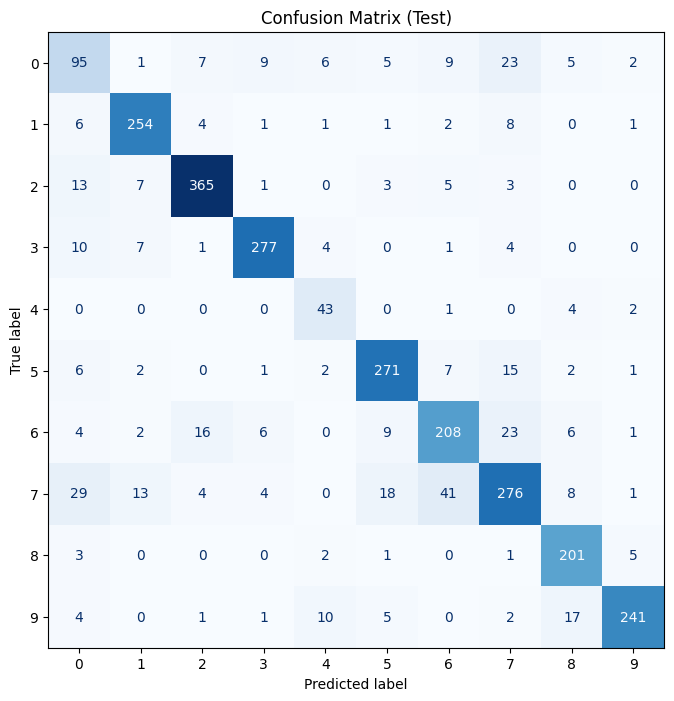


=== Classification Report (per class) ===
              precision    recall  f1-score   support

           0      0.559     0.586     0.572       162
           1      0.888     0.914     0.901       278
           2      0.917     0.919     0.918       397
           3      0.923     0.911     0.917       304
           4      0.632     0.860     0.729        50
           5      0.866     0.883     0.874       307
           6      0.759     0.756     0.758       275
           7      0.777     0.701     0.737       394
           8      0.827     0.944     0.882       213
           9      0.949     0.858     0.901       281

    accuracy                          0.838      2661
   macro avg      0.810     0.833     0.819      2661
weighted avg      0.841     0.838     0.838      2661



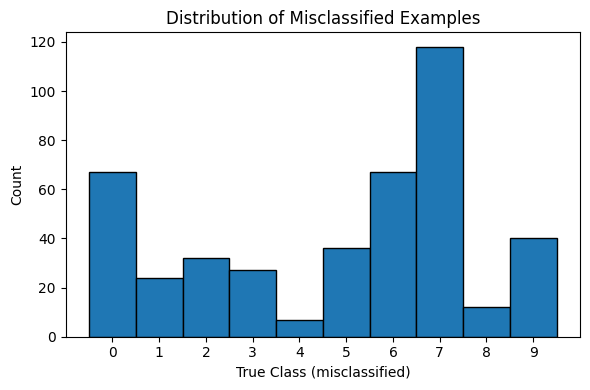

In [ ]:
# Collect predictions and truths (classification) 
def collect_preds(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits = model(xb)              # [B, 10]
            preds = logits.argmax(dim=1)        # class indices
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Get predictions
y_true, y_pred = collect_preds(model, test_loader, device)

# Confusion Matrix 
cm = confusion_matrix(y_true, y_pred, labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix (Test)")
plt.show()

# Classification Report 
print("\n=== Classification Report (per class) ===")
print(classification_report(y_true, y_pred, digits=3))

# Error Distribution 
errors = y_pred != y_true
plt.figure(figsize=(6,4))
plt.hist(y_true[errors], bins=np.arange(11)-0.5, edgecolor="black")
plt.xticks(range(10))
plt.xlabel("True Class (misclassified)")
plt.ylabel("Count")
plt.title("Distribution of Misclassified Examples")
plt.tight_layout()
plt.show()